In [157]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(1)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  OrdinalEncoder #We use the ordinal encoder for the labels as there are only two values and it will work for what we need. 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score,auc
import statistics as stats
import warnings
warnings.filterwarnings("ignore")
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, History, LearningRateScheduler
from tensorflow.keras import regularizers
# from tensorflow.keras.layers import Recurrent_Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers 
import time
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

## Importing the data

In [3]:
df=pd.read_csv('diabetes_data.csv')


## Data exploration

Exploring our data and checking for missing values and outliers

In [6]:
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


### Checking for missing values

In [5]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

We can see that there are no null values. 

In [7]:
# Looking at the age distribution
df.describe()

,Age
count,520.000000
mean,48.028846
std,12.151466
min,16.000000
25%,39.000000
50%,47.500000
75%,57.000000
max,90.000000


### Checking for outliers

In [8]:
df.Age.value_counts()

35    30
48    28
43    25
30    25
40    24
55    22
47    21
53    20
38    20
50    18
45    18
58    18
54    16
39    16
60    15
57    15
68    10
42     9
72     9
28     9
66     9
61     8
67     8
56     8
46     8
36     8
49     7
44     7
37     7
62     7
27     6
65     6
34     6
32     5
64     5
70     5
69     5
51     5
33     4
41     4
52     4
59     4
31     3
63     3
85     2
90     2
25     2
29     1
79     1
26     1
16     1
Name: Age, dtype: int64

In [9]:
attr_categorical = ["Gender","Polyuria","Polydipsia", "sudden weight loss","weakness","Polyphagia","Genital thrush",
                    "visual blurring","Itching","Irritability","delayed healing","partial paresis","muscle stiffness","Alopecia","Obesity","class"]
attr_num  = ["Age"]

In [10]:
### Data distribution

In [11]:
for label in attr_categorical:
    
    print(df[label].value_counts(normalize=True))

Male      0.630769
Female    0.369231
Name: Gender, dtype: float64
No     0.503846
Yes    0.496154
Name: Polyuria, dtype: float64
No     0.551923
Yes    0.448077
Name: Polydipsia, dtype: float64
No     0.582692
Yes    0.417308
Name: sudden weight loss, dtype: float64
Yes    0.586538
No     0.413462
Name: weakness, dtype: float64
No     0.544231
Yes    0.455769
Name: Polyphagia, dtype: float64
No     0.776923
Yes    0.223077
Name: Genital thrush, dtype: float64
No     0.551923
Yes    0.448077
Name: visual blurring, dtype: float64
No     0.513462
Yes    0.486538
Name: Itching, dtype: float64
No     0.757692
Yes    0.242308
Name: Irritability, dtype: float64
No     0.540385
Yes    0.459615
Name: delayed healing, dtype: float64
No     0.569231
Yes    0.430769
Name: partial paresis, dtype: float64
No     0.625
Yes    0.375
Name: muscle stiffness, dtype: float64
No     0.655769
Yes    0.344231
Name: Alopecia, dtype: float64
No     0.830769
Yes    0.169231
Name: Obesity, dtype: float64
Positi

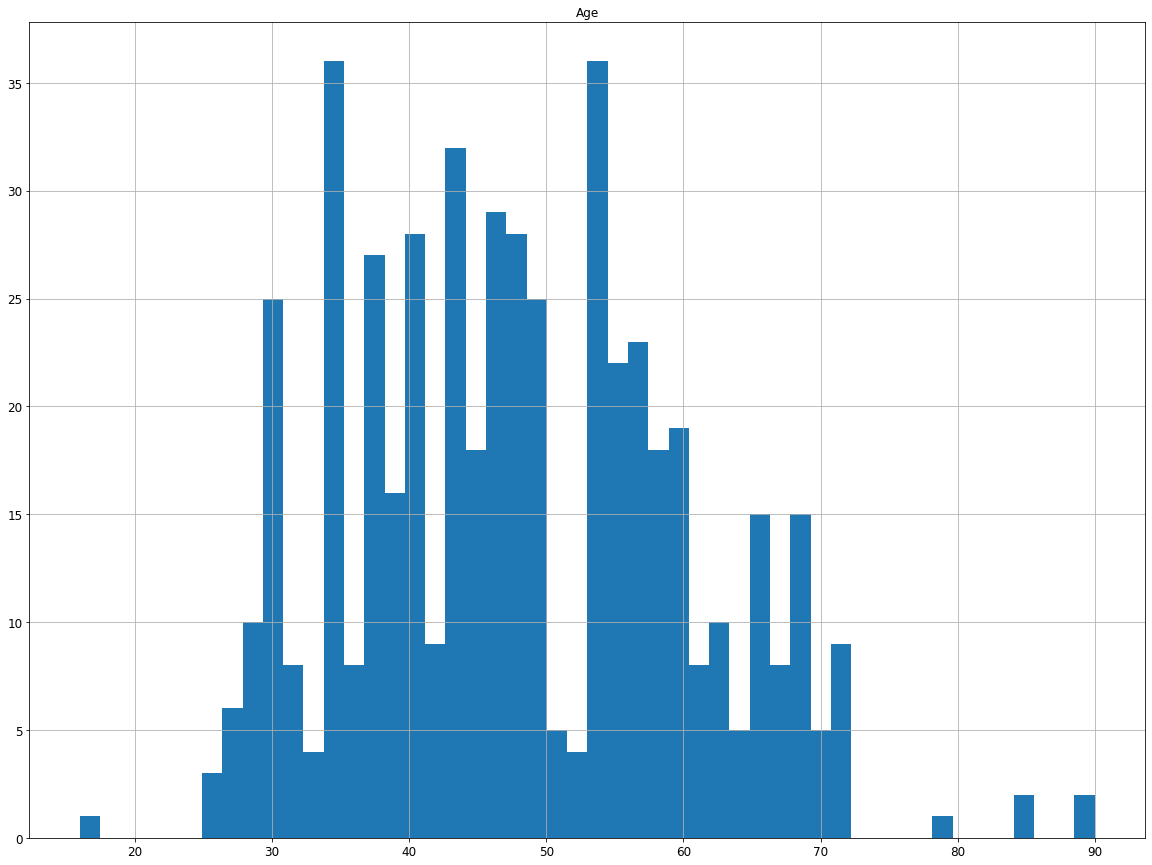

In [12]:

import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

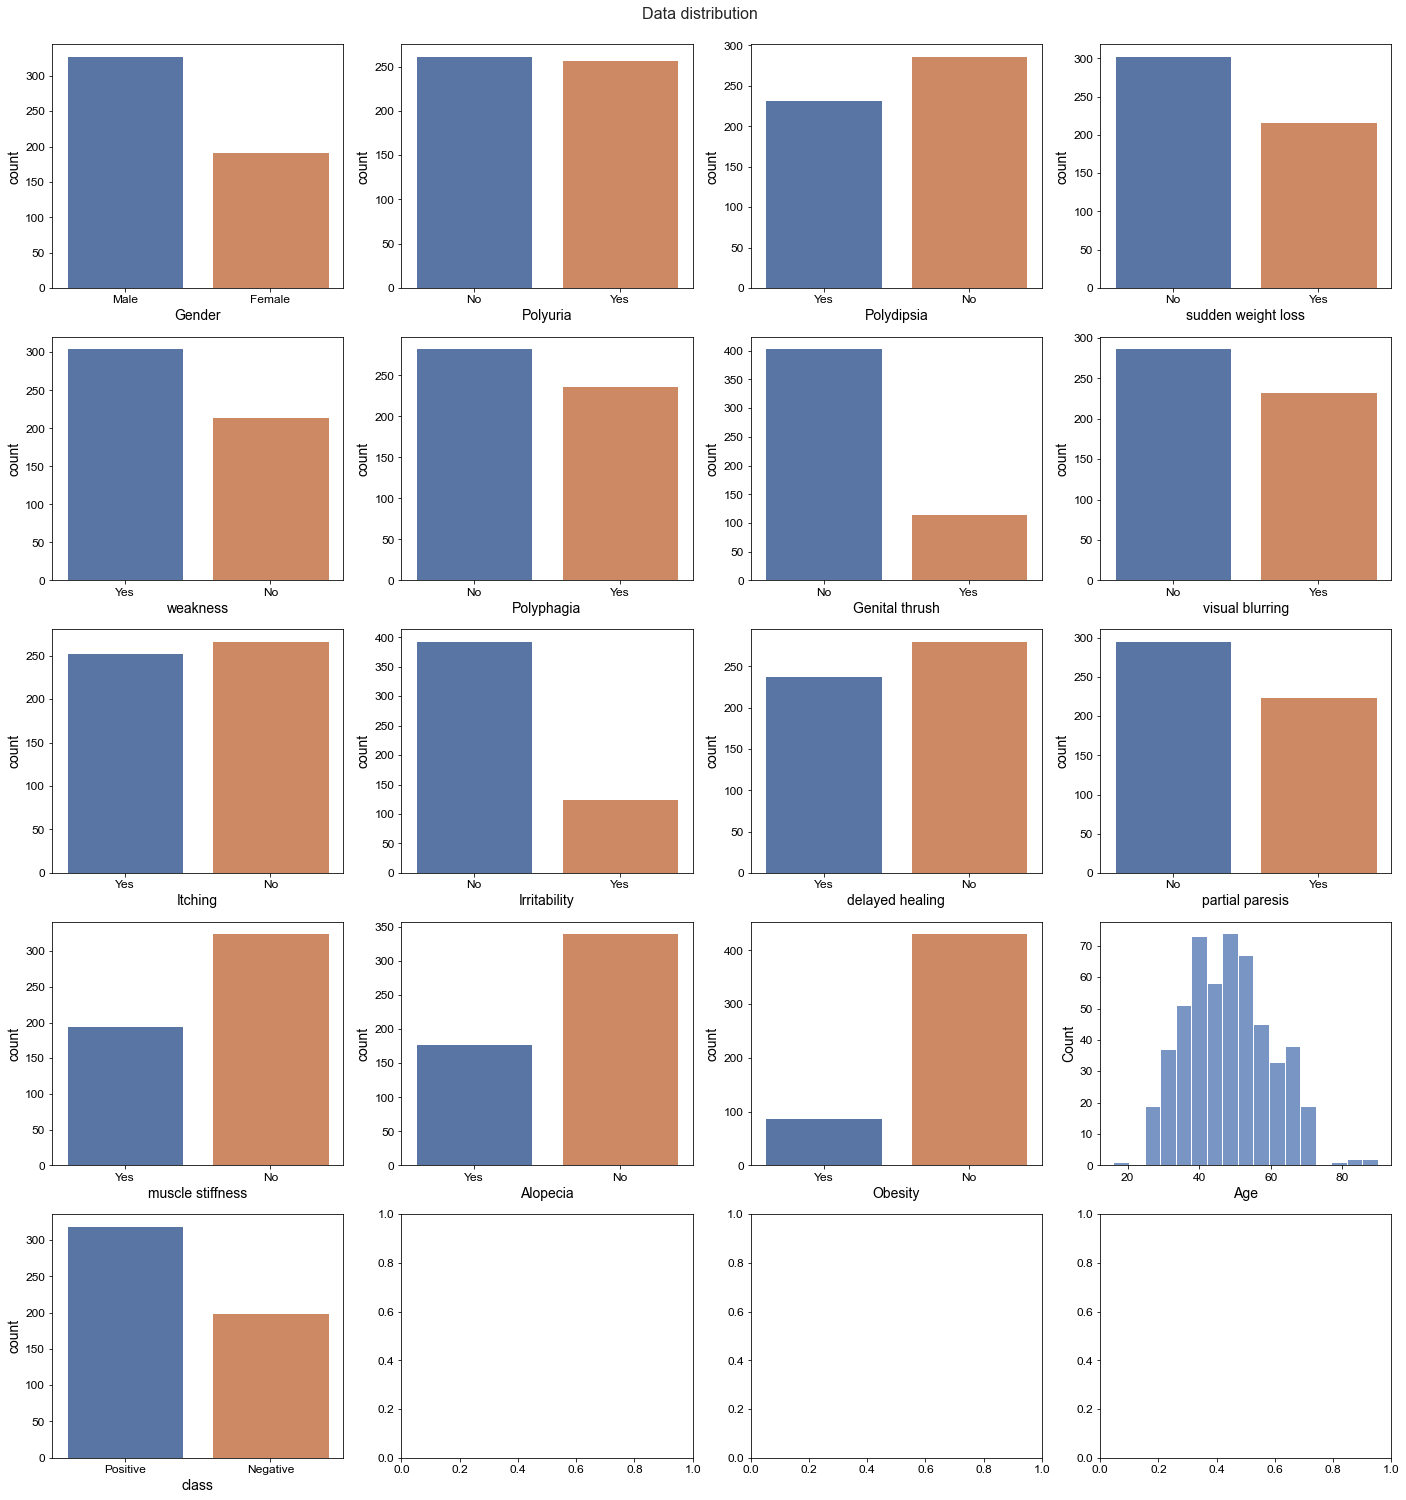

In [13]:


fig, ax =plt.subplots(5,4, figsize=(24
                                    , 26))
   
sns.set( {'axes.labelsize' : 16 })
sns.countplot(ax = ax[0,0], x = df['Gender'])

sns.countplot(ax = ax[0,1], x = df['Polyuria'])

sns.countplot(ax = ax[0,2], x = df['Polydipsia'])

sns.countplot(ax = ax[0,3], x = df['sudden weight loss'])

sns.countplot(ax = ax[1,0], x = df['weakness'])

sns.countplot(ax = ax[1,1], x = df['Polyphagia'])

sns.countplot(ax = ax[1,2], x = df['Genital thrush'])

sns.countplot(ax = ax[1,3], x = df['visual blurring'])

sns.countplot(ax = ax[2,0], x = df['Itching'])

sns.countplot(ax = ax[2,1], x = df['Irritability'])

sns.countplot(ax = ax[2,2], x = df['delayed healing'])

sns.countplot(ax = ax[2,3], x = df['partial paresis'])

sns.countplot(ax = ax[3,0], x = df['muscle stiffness'])

sns.countplot(ax = ax[3,1], x = df['Alopecia'])

sns.countplot(ax = ax[3,2], x = df['Obesity'])
sns.histplot(ax=ax[3,3], x=df['Age'])
sns.countplot(ax = ax[4,0], x = df['class'])

fig.suptitle('Data distribution', y =0.9, size = 16)  

plt.savefig('data_vis.png')

### Checking for imbalanced data

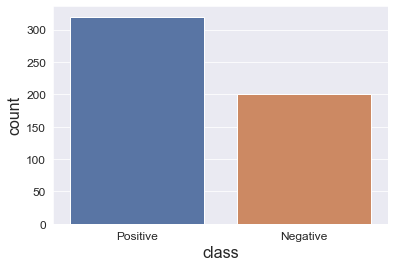

In [14]:
ax = sns.countplot(x = df["class"])  
plt.show()

We can see that the minority class os approximately 38% of the data, so we have a mildly imbalanced dataset. 
https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data

## Data preparation

### Handling Categorical data

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  OrdinalEncoder #We use the ordinal encoder for the labels as there are only two values and it will work for what we need. 
ordinal_encoder = OrdinalEncoder()
num_pipeline = Pipeline([('std_scaler', StandardScaler()) # Scaling numerical values
 ])




full_pipeline = ColumnTransformer([
        ("num", num_pipeline, attr_num), #Scaling the data with Standard scalar
        ("cat", ordinal_encoder, attr_categorical), # Transforming categorical data  
    ])

data_prepared = full_pipeline.fit_transform(df)

data = pd.DataFrame(data_prepared, columns = df.columns)

## Looking for colinearity and correlations 

In [16]:
corr_matrix = data.corr(method = "pearson")

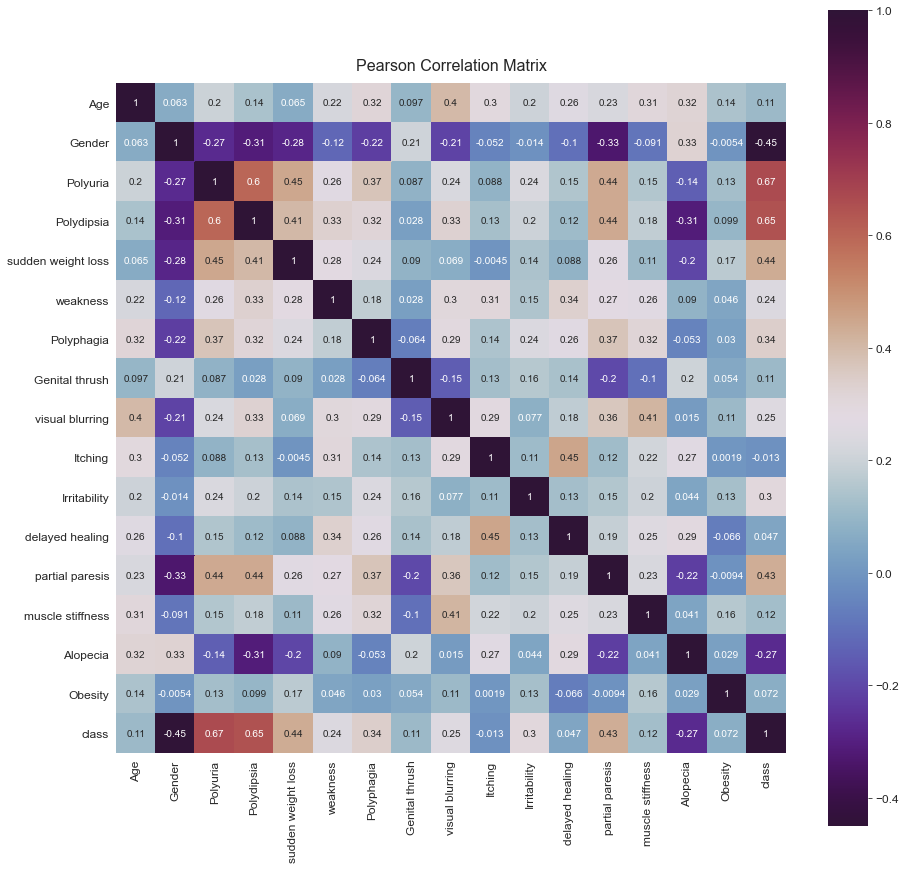

In [17]:
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix,square=True,annot=True,cmap= 'twilight_shifted')

plt.title('Pearson Correlation Matrix', y =1.01, size = 16)  

plt.savefig('Pearson correlation.png')

In [18]:
corr_matrix = data.corr(method = "spearman")

<AxesSubplot:title={'center':'Spearman Correlation Matrix'}>

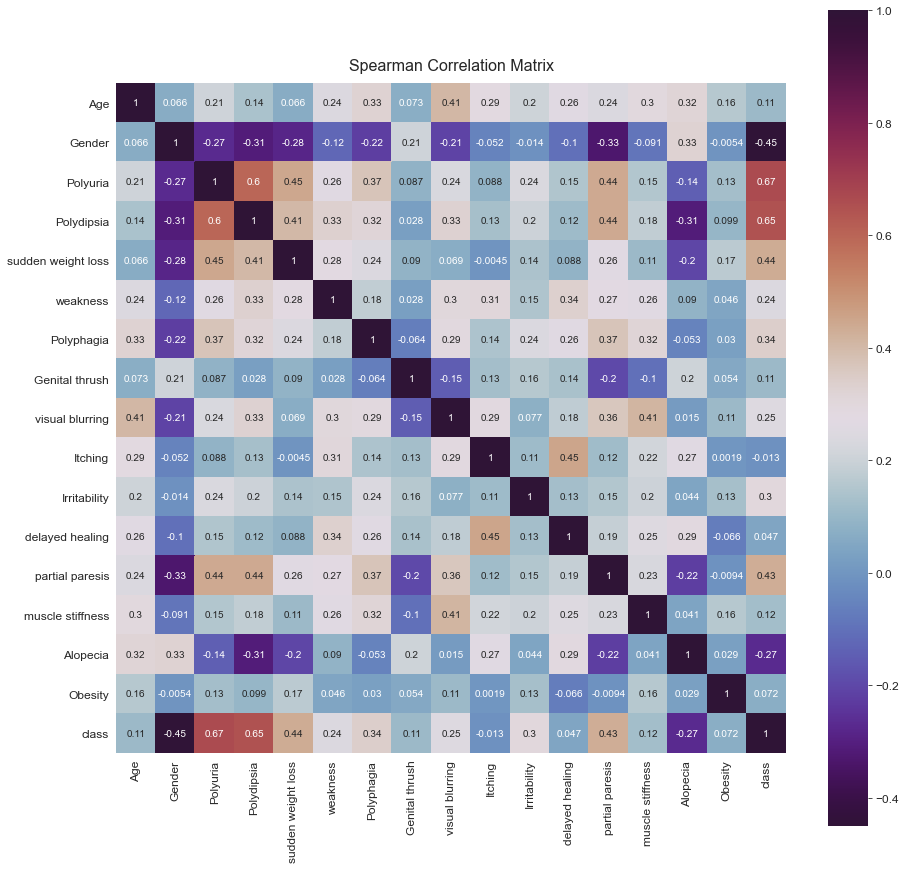

In [19]:
plt.figure(figsize=(15,15))
plt.title('Spearman Correlation Matrix', y =1.01, size = 16) 
sns.heatmap(corr_matrix,square=True,annot=True,cmap= 'twilight_shifted')

There is a moderetely increased correlation between polyuria and polydipsia which makes sense as increased thirst would lead to increased urination. Overall there are no stong correlations in our dataset. 

## Preparing the data for Machine learning algorithms
### Splitting the data

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
data_labels = data['class']
data_p = data.drop('class', axis = 1)

In [22]:
df_train, df_test,train_labels,test_labels = train_test_split(data_p, data_labels, train_size = 0.8)

In [23]:
df_train.shape, train_labels.shape, df_test.shape, test_labels.shape

((416, 16), (416,), (104, 16), (104,))

In [24]:
##### Loading the Machne learning models

In [25]:
forest = RandomForestClassifier()

knn = KNeighborsClassifier()
XGB = XGBClassifier()
voting_clf = VotingClassifier(
 estimators=[('forest', forest), ('knn', knn), ('xgb', XGB)],
 voting='soft'
 )

In [27]:
smote= SMOTE()
df_train,train_labels = smote.fit_resample(df_train,train_labels)
df_train.shape, train_labels.shape, df_test.shape, test_labels.shape

((508, 16), (508,), (104, 16), (104,))

In [28]:
classifiers = [forest,knn,XGB,voting_clf]
from sklearn.metrics import plot_confusion_matrix

### Classification report and confusion matrices

We run all classifiers once to estimate their performance

In [34]:
for clf in classifiers:
    clf.fit(df_train,train_labels)
    y_pred = clf.predict(df_test)
    f_probs = clf.predict_proba(df_test)[:, 1]
    clf_auc = roc_auc_score(test_labels,f_probs)
    print('Train accuracy: {}'.format(clf.score(df_train, train_labels)))
    print('Test accuracy: {}'.format(clf.score(df_test, test_labels)))
    print('AUC score: ',(clf_auc))
    print('For Classifier',clf,classification_report(test_labels, y_pred,digits=3))



Train accuracy: 1.0
Test accuracy: 0.9807692307692307
AUC score:  0.9972089314194577
For Classifier RandomForestClassifier()               precision    recall  f1-score   support

         0.0      1.000     0.947     0.973        38
         1.0      0.971     1.000     0.985        66

    accuracy                          0.981       104
   macro avg      0.985     0.974     0.979       104
weighted avg      0.981     0.981     0.981       104

Train accuracy: 0.9586614173228346
Test accuracy: 0.8942307692307693
AUC score:  0.9621212121212122
For Classifier KNeighborsClassifier()               precision    recall  f1-score   support

         0.0      0.800     0.947     0.867        38
         1.0      0.966     0.864     0.912        66

    accuracy                          0.894       104
   macro avg      0.883     0.906     0.890       104
weighted avg      0.905     0.894     0.896       104

[22:57:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

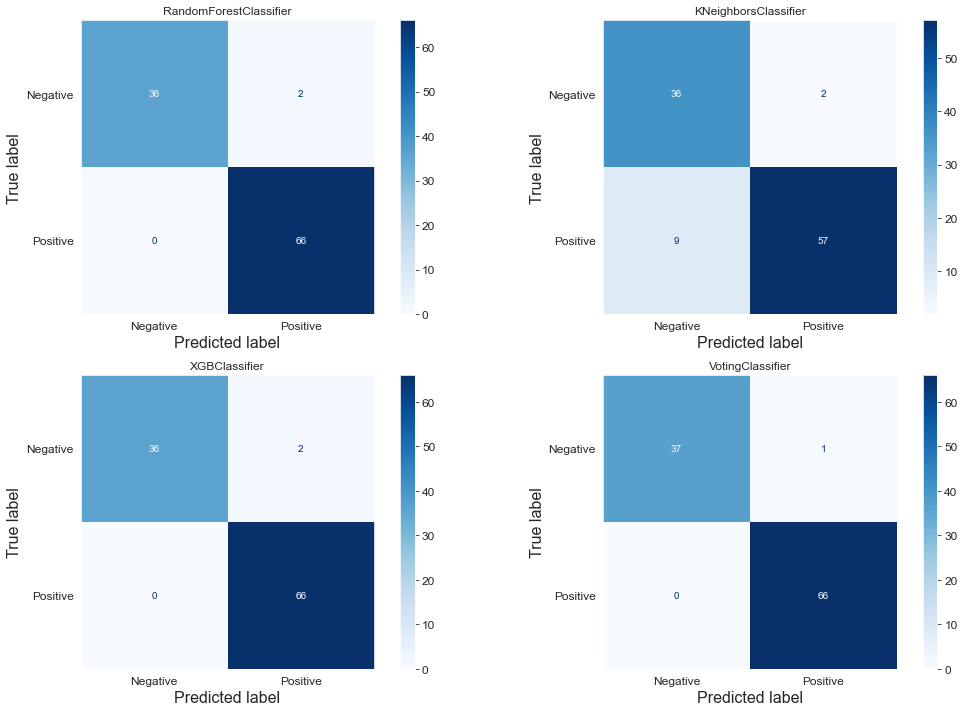

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          df_test, 
                          test_labels, 
                          ax=ax, 
                          cmap='Blues',
                         display_labels=['Negative','Positive'])
    ax.title.set_text(type(cls).__name__)
    ax.grid(False)
    plt.grid(False)

plt.tight_layout()

#plt.show()

plt.savefig('conf_matrix.png')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               8704      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262144    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 271,361
Trainable params: 271,361
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1500
16/16 [==============================] - 1s 5ms/step - loss: 4.9625 - auc_1: 0.9091 - accuracy: 0.7972
Epoch 2/1500
16/16 [==============================] - 0s 5ms/step - loss: 3.2036 - auc_1: 0.9718 - accuracy: 0.9370
Epoch 3/1

16/16 [==============================] - 0s 5ms/step - loss: 0.1630 - auc_1: 0.9988 - accuracy: 0.9803
Epoch 64/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.1639 - auc_1: 0.9985 - accuracy: 0.9744
Epoch 65/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.1593 - auc_1: 0.9990 - accuracy: 0.9764
Epoch 66/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.1565 - auc_1: 0.9988 - accuracy: 0.9783
Epoch 67/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.1576 - auc_1: 0.9990 - accuracy: 0.9744
Epoch 68/1500
16/16 [==============================] - ETA: 0s - loss: 0.1601 - auc_1: 0.9985 - accuracy: 0.97 - 0s 5ms/step - loss: 0.1584 - auc_1: 0.9988 - accuracy: 0.9764
Epoch 69/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.1545 - auc_1: 0.9991 - accuracy: 0.9823
Epoch 70/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.1538 - auc_1: 0.9990 - accuracy: 0.9783
Epoch 71/1500
16/16 

16/16 [==============================] - 0s 5ms/step - loss: 0.1099 - auc_1: 0.9997 - accuracy: 0.9902
Epoch 133/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.1106 - auc_1: 0.9998 - accuracy: 0.9921
Epoch 134/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.1137 - auc_1: 0.9996 - accuracy: 0.9843
Epoch 135/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.1080 - auc_1: 0.9998 - accuracy: 0.9921
Epoch 136/1500
16/16 [==============================] - 0s 4ms/step - loss: 0.1087 - auc_1: 0.9998 - accuracy: 0.9921
Epoch 137/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.1106 - auc_1: 0.9996 - accuracy: 0.9902
Epoch 138/1500
16/16 [==============================] - 0s 4ms/step - loss: 0.1095 - auc_1: 0.9997 - accuracy: 0.9882
Epoch 139/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.1102 - auc_1: 0.9997 - accuracy: 0.9882
Epoch 140/1500
16/16 [==============================] - 0s 4ms/step - l

16/16 [==============================] - 0s 5ms/step - loss: 0.0861 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 202/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0863 - auc_1: 0.9998 - accuracy: 0.9941
Epoch 203/1500
16/16 [==============================] - 0s 4ms/step - loss: 0.0869 - auc_1: 0.9998 - accuracy: 0.9921
Epoch 204/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0860 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 205/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0852 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 206/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0884 - auc_1: 0.9998 - accuracy: 0.9941
Epoch 207/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0847 - auc_1: 0.9998 - accuracy: 0.9941
Epoch 208/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0855 - auc_1: 0.9998 - accuracy: 0.9941
Epoch 209/1500
16/16 [==============================] - 0s 4ms/step - l

16/16 [==============================] - 0s 4ms/step - loss: 0.0747 - auc_1: 0.9999 - accuracy: 0.9921
Epoch 271/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0722 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 272/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0716 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 273/1500
16/16 [==============================] - 0s 4ms/step - loss: 0.0705 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 274/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0717 - auc_1: 0.9999 - accuracy: 0.9902
Epoch 275/1500
16/16 [==============================] - 0s 4ms/step - loss: 0.0696 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 276/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0765 - auc_1: 0.9997 - accuracy: 0.9941
Epoch 277/1500
16/16 [==============================] - 0s 4ms/step - loss: 0.0722 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 278/1500
16/16 [==============================] - 0s 4ms/step - l

16/16 [==============================] - 0s 4ms/step - loss: 0.0652 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 340/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0669 - auc_1: 0.9998 - accuracy: 0.9902
Epoch 341/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0655 - auc_1: 0.9999 - accuracy: 0.9961
Epoch 342/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0649 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 343/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0632 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 344/1500
16/16 [==============================] - 0s 4ms/step - loss: 0.0628 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 345/1500
16/16 [==============================] - 0s 4ms/step - loss: 0.0662 - auc_1: 0.9998 - accuracy: 0.9921
Epoch 346/1500
16/16 [==============================] - 0s 4ms/step - loss: 0.0713 - auc_1: 0.9997 - accuracy: 0.9921
Epoch 347/1500
16/16 [==============================] - 0s 4ms/step - l

16/16 [==============================] - 0s 5ms/step - loss: 0.0579 - auc_1: 1.0000 - accuracy: 0.9921
Epoch 409/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0665 - auc_1: 0.9998 - accuracy: 0.9882
Epoch 410/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0692 - auc_1: 0.9997 - accuracy: 0.9902
Epoch 411/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0679 - auc_1: 0.9997 - accuracy: 0.9882
Epoch 412/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0608 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 413/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0626 - auc_1: 0.9999 - accuracy: 0.9961
Epoch 414/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0581 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 415/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0570 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 416/1500
16/16 [==============================] - 0s 5ms/step - l

16/16 [==============================] - 0s 5ms/step - loss: 0.0566 - auc_1: 0.9999 - accuracy: 0.9961
Epoch 478/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0575 - auc_1: 0.9999 - accuracy: 0.9902
Epoch 479/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0517 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 480/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0527 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 481/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0532 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 482/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0526 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 483/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0528 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 484/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0535 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 485/1500
16/16 [==============================] - 0s 5ms/step - l

16/16 [==============================] - 0s 6ms/step - loss: 0.0504 - auc_1: 0.9999 - accuracy: 0.9921
Epoch 547/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0509 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 548/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0509 - auc_1: 0.9999 - accuracy: 0.9921
Epoch 549/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0535 - auc_1: 0.9998 - accuracy: 0.9941
Epoch 550/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0506 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 551/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0512 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 552/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0515 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 553/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0481 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 554/1500
16/16 [==============================] - 0s 6ms/step - l

16/16 [==============================] - 0s 5ms/step - loss: 0.0500 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 616/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0465 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 617/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0473 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 618/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0483 - auc_1: 0.9999 - accuracy: 0.9902
Epoch 619/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0481 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 620/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0478 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 621/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0467 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 622/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0486 - auc_1: 0.9999 - accuracy: 0.9921
Epoch 623/1500
16/16 [==============================] - 0s 5ms/step - l

16/16 [==============================] - 0s 5ms/step - loss: 0.0441 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 685/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0461 - auc_1: 0.9999 - accuracy: 0.9961
Epoch 686/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0463 - auc_1: 0.9999 - accuracy: 0.9961
Epoch 687/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0427 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 688/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0451 - auc_1: 0.9999 - accuracy: 0.9961
Epoch 689/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0497 - auc_1: 0.9998 - accuracy: 0.9921
Epoch 690/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0538 - auc_1: 0.9999 - accuracy: 0.9921
Epoch 691/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0494 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 692/1500
16/16 [==============================] - 0s 5ms/step - l

16/16 [==============================] - 0s 5ms/step - loss: 0.0438 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 754/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0432 - auc_1: 1.0000 - accuracy: 0.9921
Epoch 755/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0440 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 756/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0439 - auc_1: 1.0000 - accuracy: 0.9921
Epoch 757/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0456 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 758/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0420 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 759/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0420 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 760/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0433 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 761/1500
16/16 [==============================] - 0s 5ms/step - l

Epoch 822/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0393 - auc_1: 1.0000 - accuracy: 1.0000
Epoch 823/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0430 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 824/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0405 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 825/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0421 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 826/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0409 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 827/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0419 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 828/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0419 - auc_1: 0.9999 - accuracy: 0.9921
Epoch 829/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0416 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 830/1500
16/16 [==============================] - 

16/16 [==============================] - 0s 5ms/step - loss: 0.0393 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 891/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0380 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 892/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0395 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 893/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0401 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 894/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0402 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 895/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0397 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 896/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0396 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 897/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0399 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 898/1500
16/16 [==============================] - 0s 5ms/step - l

16/16 [==============================] - 0s 5ms/step - loss: 0.0404 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 959/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0384 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 960/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0393 - auc_1: 0.9999 - accuracy: 0.9961
Epoch 961/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0406 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 962/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0385 - auc_1: 1.0000 - accuracy: 1.0000
Epoch 963/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0431 - auc_1: 0.9999 - accuracy: 0.9921
Epoch 964/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0390 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 965/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0384 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 966/1500
16/16 [==============================] - 0s 5ms/step - l

16/16 [==============================] - 0s 5ms/step - loss: 0.0369 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 1027/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0391 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 1028/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0386 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 1029/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0382 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 1030/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0363 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 1031/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0379 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 1032/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0375 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 1033/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0368 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1034/1500
16/16 [==============================] - 0s 5ms/

Epoch 1095/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0370 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 1096/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0353 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 1097/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0353 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1098/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0366 - auc_1: 1.0000 - accuracy: 0.9921
Epoch 1099/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0388 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 1100/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0364 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1101/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0369 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1102/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0360 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 1103/1500
16/16 [=========================

16/16 [==============================] - 0s 6ms/step - loss: 0.0346 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 1164/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0360 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1165/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0351 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 1166/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0372 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 1167/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0364 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1168/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0349 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1169/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0348 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1170/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0354 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 1171/1500
16/16 [==============================] - 0s 6ms/

16/16 [==============================] - 0s 5ms/step - loss: 0.0343 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 1232/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0322 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1233/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0350 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1234/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0377 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1235/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0347 - auc_1: 1.0000 - accuracy: 1.0000
Epoch 1236/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0340 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 1237/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0335 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 1238/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0335 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1239/1500
16/16 [==============================] - 0s 5ms/

Epoch 1300/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0328 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1301/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0332 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1302/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0351 - auc_1: 0.9999 - accuracy: 0.9961
Epoch 1303/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0334 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 1304/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0350 - auc_1: 0.9999 - accuracy: 0.9941
Epoch 1305/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0347 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 1306/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0347 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1307/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0340 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 1308/1500
16/16 [=========================

16/16 [==============================] - 0s 5ms/step - loss: 0.0310 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1369/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0325 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1370/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0323 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 1371/1500
16/16 [==============================] - 0s 7ms/step - loss: 0.0337 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1372/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0348 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 1373/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0323 - auc_1: 1.0000 - accuracy: 1.0000
Epoch 1374/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0327 - auc_1: 1.0000 - accuracy: 0.9941
Epoch 1375/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0316 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1376/1500
16/16 [==============================] - 0s 5ms/

16/16 [==============================] - 0s 5ms/step - loss: 0.0323 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1437/1500
16/16 [==============================] - 0s 6ms/step - loss: 0.0311 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1438/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0314 - auc_1: 1.0000 - accuracy: 0.9961
Epoch 1439/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0319 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 1440/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0315 - auc_1: 1.0000 - accuracy: 0.9980
Epoch 1441/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0343 - auc_1: 0.9999 - accuracy: 0.9902
Epoch 1442/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0311 - auc_1: 1.0000 - accuracy: 1.0000
Epoch 1443/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.0363 - auc_1: 0.9999 - accuracy: 0.9921
Epoch 1444/1500
16/16 [==============================] - 0s 5ms/

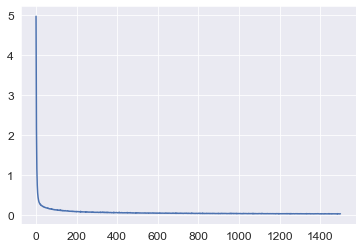

4/4 [==============================] - 0s 2ms/step - loss: 0.0841 - auc_1: 0.9972 - accuracy: 0.9808
Test loss: 0.08405529707670212
Test AUC (from tf): 0.9972089529037476
Test accuracy: 0.9807692170143127
4/4 [==============================] - 0s 2ms/step - loss: 0.0841 - auc_1: 0.9972 - accuracy: 0.9808
[0.08405529707670212, 0.9972089529037476, 0.9807692170143127]


In [37]:
#MLNN first run
np.random.seed(1)
smote= SMOTE()
X_train, X_test, y_train, y_test = train_test_split(data_p, data_labels, train_size = 0.8, shuffle=True)
X_train,y_train = smote.fit_resample(X_train,y_train)
input_dim = 16
num_classes = 1
num_epochs = 1500
layer_dim = 1
learning_rate = 0.001
batch_size =32#int(opt)32
dropout=0.05
hidden_dim=512
output_activation = 'sigmoid'
initial_activation = 'relu'
kernel_initializer="glorot_uniform"
bias_initializer="glorot_uniform"
loss_function=tf.keras.losses.BinaryCrossentropy()
optimiser=optimizers.Adamax(lr=learning_rate)
metric=tf.keras.metrics.AUC()#,tf.keras.metrics.Accuracy()
kernel_regularizer='l2' # ,'l1'

##Building the MLP
        
history = History()
model = Sequential()

#Add input layer
model.add(Dense(hidden_dim, input_dim=input_dim, activation=initial_activation, use_bias=True, bias_initializer=bias_initializer, kernel_initializer=kernel_initializer,kernel_regularizer=kernel_regularizer))
model.add(Dropout(dropout))
#Add hidden layer
model.add(Dense(hidden_dim, activation=initial_activation, use_bias=False, bias_initializer=bias_initializer, kernel_initializer=kernel_initializer,kernel_regularizer=kernel_regularizer))
#Add output layer
model.add(Dense(units=num_classes, activation=output_activation))
   
sgd=optimizers.Adamax(lr=learning_rate)     
model.compile(loss=loss_function,
              optimizer=optimiser,
              metrics=[metric,'accuracy']) 
print(model.summary())
model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, callbacks=[history])
plt.plot(history.history['loss'], label='train')
plt.show()

#Model Evaluation
score =(loss, AUC,accuracy) = model.evaluate(X_test, y_test, verbose=1)
#y_pred=model.predict(X_test)
#print('Test AUC (from sklearn):',custom_auc(y_test, y_pred))
print('Test loss:',score[0])
print('Test AUC (from tf):',score[1])
print('Test accuracy:',score[2])
print(model.evaluate(X_test, y_test, verbose=1))
#print('Test f1-score:',score[3])
#print('Test precision:',score[4])
#print('Test recall:',score[5])

In [46]:
mnn_pred = model.predict_classes(X_test)

In [47]:
# precision tp / (tp + fp)
precision = precision_score(y_test, mnn_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, mnn_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, mnn_pred)
print('F1 score: %f' % f1)

Precision: 0.984848
Recall: 0.984848
F1 score: 0.984848


In [48]:
cm = confusion_matrix(y_true=y_test, y_pred=mnn_pred.round())

Confusion matrix, without normalization
[[37  1]
 [ 1 65]]


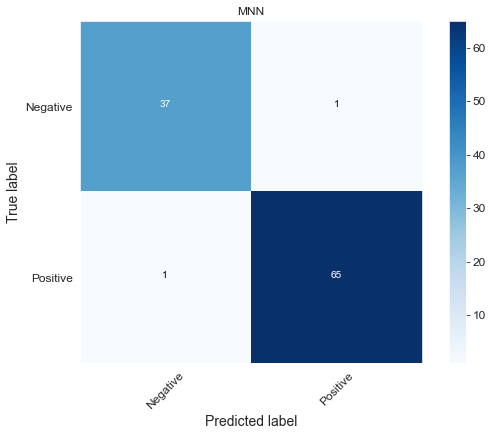

In [49]:
#Confusion map for MLNN
import itertools
from matplotlib.pyplot import figure
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    
   
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    ax.grid(False)
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.gcf().subplots_adjust(bottom=0.15)

    plt.savefig('mnn_conf_matrix.png')
    
plot_confusion_matrix(cm=cm, classes=['Negative','Positive'], title='MNN')

## Feature importance and correlation

In [50]:
importances = forest.feature_importances_

In [51]:
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.feature_names_in_)
attributes = attr_num + cat_one_hot_attribs
sorted(zip(importances, attributes), reverse=True) # Displays importance scores next to attribute names. 

[(0.2469008367433022, 'Polydipsia'),
 (0.19973727698360583, 'Polyuria'),
 (0.09140465633197202, 'Age'),
 (0.091011750969409, 'Gender'),
 (0.05676086974230413, 'sudden weight loss'),
 (0.05177760155254941, 'partial paresis'),
 (0.041164113853018255, 'Alopecia'),
 (0.03430624203109202, 'Polyphagia'),
 (0.032876508079859104, 'Irritability'),
 (0.028791384112479883, 'Itching'),
 (0.026862312936880052, 'visual blurring'),
 (0.025390337493603553, 'delayed healing'),
 (0.020449435276088092, 'Genital thrush'),
 (0.020044877773120025, 'muscle stiffness'),
 (0.01708937855467797, 'Obesity'),
 (0.015432417566038453, 'weakness')]

In [55]:
attributes

['Age',
 'Gender',
 'Polyuria',
 'Polydipsia',
 'sudden weight loss',
 'weakness',
 'Polyphagia',
 'Genital thrush',
 'visual blurring',
 'Itching',
 'Irritability',
 'delayed healing',
 'partial paresis',
 'muscle stiffness',
 'Alopecia',
 'Obesity']

<Figure size 432x288 with 0 Axes>

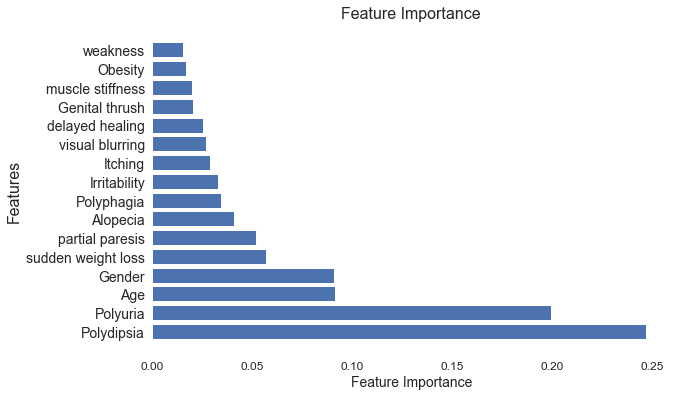

In [152]:
features = pd.DataFrame({"Importances":importances,
                  "Feature":attributes})
features_sorted_desc= features.sort_values('Importances',ascending=False)

fig = plt.figure()
plt.figure(figsize = (12,6))
plt.subplots_adjust(left=0.3)
plt.barh('Feature','Importances',data = features_sorted_desc)
plt.title('')
plt.ylabel('')
plt.xlabel('Feature Importance')
plt.title('Feature Importance', y =1.01, size = 16)

plt.yticks(fontsize=14)
fig.suptitle('', fontsize=14, fontweight='bold')
ax = plt.axes()

ax.set_facecolor('white')
ax.set_ylabel('Features', fontsize=16)

plt.savefig('Feature Importance .png')

In [57]:
xg_importances = XGB.feature_importances_

<Figure size 432x288 with 0 Axes>

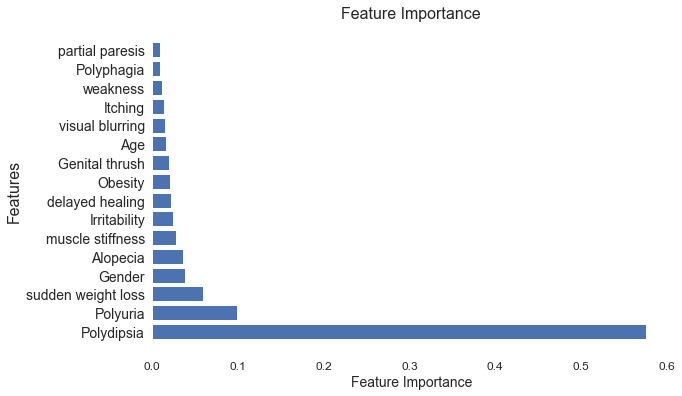

In [153]:
features = pd.DataFrame({"Importances":xg_importances,
                  "Feature":attributes})
features_sorted_desc= features.sort_values('Importances',ascending=False)

fig = plt.figure()
plt.figure(figsize = (12,6))
plt.subplots_adjust(left=0.3)
plt.barh('Feature','Importances',data = features_sorted_desc)
plt.title('')
plt.ylabel('')
plt.xlabel('Feature Importance')
plt.title('Feature Importance', y =1.01, size = 16)

plt.yticks(fontsize=14)
fig.suptitle('', fontsize=14, fontweight='bold')
ax = plt.axes()

ax.set_facecolor('white')
ax.set_ylabel('Features', fontsize=16)

plt.savefig('Feature Importance_xg .png')

In [70]:
corr  = []
for feature in data_p:
    corr.append(np.corrcoef(data_p[feature],data_labels)[0][1])
    print(feature, np.corrcoef(data_p[feature],data_labels)[0][1])

Age 0.10867899854466134
Gender -0.4492333585023052
Polyuria 0.6659224017308114
Polydipsia 0.6487337304599204
sudden weight loss 0.4365681826150604
weakness 0.24327477330369177
Polyphagia 0.34250386354385853
Genital thrush 0.11028774943290126
visual blurring 0.25130024808579376
Itching -0.01338371851114166
Irritability 0.29946706887473235
delayed healing 0.046979524748752145
partial paresis 0.43228762054052294
muscle stiffness 0.1224744871391591
Alopecia -0.2675115767280865
Obesity 0.07217333961497473


<Figure size 432x288 with 0 Axes>

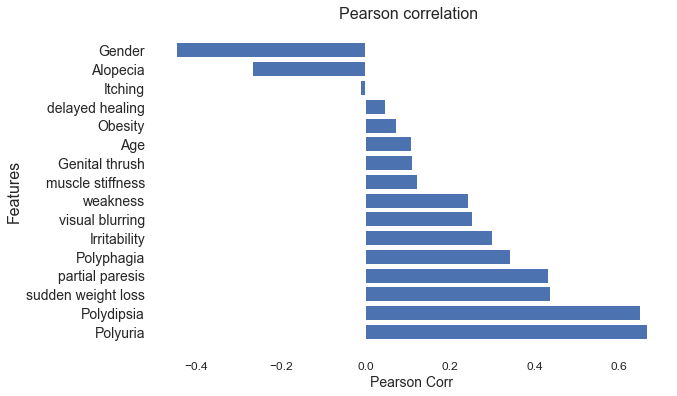

In [146]:
features = pd.DataFrame({"Pearson Corr":corr,
                  "Feature":attributes})
features_sorted_desc= features.sort_values('Pearson Corr',ascending=False)
fig = plt.figure()
plt.figure(figsize = (12,6))
plt.subplots_adjust(left=0.3)
plt.barh('Feature','Pearson Corr',data = features_sorted_desc)
plt.title('')
plt.ylabel('')
plt.xlabel('Pearson Corr')
plt.title('Pearson correlation ', y =1.01, size = 16)
plt.yticks(fontsize=14)
fig.suptitle('', fontsize=14, fontweight='bold')
ax = plt.axes()
ax.set_facecolor('white')
ax.set_ylabel('Features', fontsize=16)
plt.savefig('Pearson Correlation .png')


# Estimating the best models

In [154]:
stat_forest = []
stat_knn = []
stat_XGB = []
AUC_forest = []
AUC_knn = []
AUC_XGB = []

In [158]:
mf = []

forest = RandomForestClassifier(random_state=1)
for times in range(5):
    df_train, df_test,train_labels,test_labels = train_test_split(data_p, data_labels, train_size = 0.8, shuffle=True)
    df_train,train_labels = smote.fit_resample(df_train,train_labels)
    param_grid = [
    # try 12 (3×4) combinations of hyperparameters
     # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [ 50,100], 'max_features': [2,3, 4], 'criterion': ['gini','entropy'],'max_depth' : [10,20]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [50,100], 'max_features': [2, 3, 4],'criterion': ['gini','entropy'],'max_depth' : [10,20]},
  ]
    grid = GridSearchCV(forest,param_grid, cv=10,return_train_score=True) 
    
    
    

    
    grid.fit(df_train,train_labels)
    forest = grid.best_estimator_
    f_probs = forest.predict_proba(df_test)[:, 1]
    forest_auc = roc_auc_score(test_labels,f_probs)
    stat_forest.append(forest.score(df_test, test_labels))
    
    AUC_forest.append(forest_auc)
    mf.append(forest)
print("  Mean AUC ", round(stats.mean(AUC_forest),3),"  Mean ACC ", round(stats.mean(stat_forest),3))    

  Mean AUC  0.999   Mean ACC  0.983


In [159]:
t = zip(mf,AUC_forest, stat_forest)
print(list(t))

[(RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       max_features=3, n_estimators=50, random_state=1), 0.9988038277511961, 0.9807692307692307), (RandomForestClassifier(bootstrap=False, max_depth=10, max_features=2,
                       n_estimators=50, random_state=1), 1.0, 1.0), (RandomForestClassifier(bootstrap=False, max_depth=10, max_features=2,
                       random_state=1), 0.9996159754224271, 0.9807692307692307), (RandomForestClassifier(bootstrap=False, max_depth=20, max_features=2,
                       random_state=1), 0.9995966115369099, 0.9807692307692307), (RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=20,
                       max_features=2, n_estimators=50, random_state=1), 0.9992257065427798, 0.9807692307692307)]


In [161]:
kn = []
knn = KNeighborsClassifier()
for times in range(5):
    df_train, df_test,train_labels,test_labels = train_test_split(data_p, data_labels, train_size = 0.8, shuffle=True)
    df_train,train_labels = smote.fit_resample(df_train,train_labels)    
    param_grid = [
        # try 12 (3×4) combinations of hyperparameters
        {'n_neighbors': [ 3,5,11,19], 'weights': ['uniforn','distance'], 'metric': ['minkowski','manhattan','euclidean']},
        # then try 6 (2×3) combinations with bootstrap set as False
        #{'bootstrap': [False], 'n_estimators': [50,100,200], 'max_features': [2, 3, 4],'criterion': ['gini','entropy']},
     ]


    # train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
    grid = GridSearchCV(knn, param_grid, cv=20, return_train_score=True)                       

    grid.fit(df_train,train_labels)

    knn2 = grid.best_estimator_
    g_probs = knn2.predict_proba(df_test)[:, 1]
    knn_auc = roc_auc_score(test_labels,g_probs)   
    stat_knn.append(knn2.score(df_test, test_labels))
    
    AUC_knn.append(knn_auc)
    kn.append(knn2)

k = zip(kn,AUC_knn, stat_knn)
print(list(k))

[(KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance'), 0.958984375, 0.9519230769230769), (KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance'), 0.9823838080959522, 0.9807692307692307), (KNeighborsClassifier(n_neighbors=3, weights='distance'), 0.9767441860465117, 0.9326923076923077), (KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance'), 0.9511562998405103, 0.9423076923076923), (KNeighborsClassifier(metric='manhattan', weights='distance'), 0.9552795031055901, 0.9230769230769231)]


In [162]:
xg = []
XGB = XGBClassifier(use_label_encoder=False, eval_metric = 'auc')
for times in range(10):
    df_train, df_test,train_labels,test_labels = train_test_split(data_p, data_labels, train_size = 0.8, shuffle=True)
    df_train,train_labels = smote.fit_resample(df_train,train_labels)    
    param_grid = [
         
    { 'gamma': [0,1,5],
              'learning_rate': [0.01, 0.1],
              'max_depth': [10,20],
              'n_estimators': [50,100],
              }
 ]


    # train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
    XGBCL = GridSearchCV(XGB, param_grid, cv=10, return_train_score=True)                       

    XGBCL.fit(df_train,train_labels)

    XGB = XGBCL.best_estimator_
    g_probs = XGB.predict_proba(df_test)[:, 1]
    XGB_auc = roc_auc_score(test_labels,g_probs)   
    stat_XGB.append(XGB.score(df_test, test_labels))
    
    AUC_XGB.append(XGB_auc)
    xg.append(XGB)

x = zip(xg,AUC_XGB, stat_XGB)
print(list(x))

[(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None), 0.9957757296466974, 0.9903846153846154), (XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weigh

In [164]:
from prettytable                     import PrettyTable
from astropy.table                   import Table, Column


# Running the models 100-200 times to evaluate overall performance

#### Machine learning models

In [165]:


forest = RandomForestClassifier(random_state = 1,bootstrap = False, criterion= 'gini',max_depth = 10, max_features= 2, n_estimators= 50)

knn = KNeighborsClassifier(metric = 'manhattan', n_neighbors= 3, weights = 'distance')

XGB = XGBClassifier(use_label_encoder=False, eval_metric = 'auc',gamma= 0, learning_rate= 0.1, max_depth= 10, n_estimators= 100)
#Voting classifier on all the best models
voting_clf = VotingClassifier(
 estimators=[('forest', forest), ('knn', knn), ('xgb', XGB)],
 voting='soft'
 )
stat_forest = []
stat_knn = []
stat_XGB = []
stat_vc = []
AUC_forest = []
AUC_knn = []
AUC_XGB = []
AUC_vc = []

for times in range(300):
    df_train, df_test,train_labels,test_labels = train_test_split(data_p, data_labels, train_size = 0.8, shuffle=True)
    df_train,train_labels = smote.fit_resample(df_train,train_labels)
    forest.fit(df_train,train_labels)
    f_probs = forest.predict_proba(df_test)[:, 1]
    forest_auc = roc_auc_score(test_labels,f_probs) 
    
    #print('Forest:')
    #print('Train accuracy: {}'.format(forest.score(df_train, train_labels)))
    #print('Test accuracy: {}'.format(forest.score(df_test, test_labels)))
     
    knn.fit(df_train,train_labels)
    k_probs = knn.predict_proba(df_test)[:, 1]
    knn_auc = roc_auc_score(test_labels,k_probs)
    #print('KNN:')
    #print('Train accuracy: {}'.format(knn.score(df_train, train_labels)))
    #print('Test accuracy: {}'.format(knn.score(df_test, test_labels)))
      
    XGB.fit(df_train,train_labels)
    XGB_pred = XGB.predict(df_test)
    X_probs = knn.predict_proba(df_test)[:, 1]
    XGB_auc = roc_auc_score(test_labels,X_probs)
    #accuracy = accuracy_score(test_labels, y_pred)
    #print('XGBoost:')
    #print('Train accuracy: {}'.format(XGB.score(df_train, train_labels)))
    #print('Test accuracy: {}'.format(XGB.score(df_test, test_labels)))
    
    voting_clf.fit(df_train,train_labels)
    vc_pred = voting_clf.predict(df_test)
    vc_probs = voting_clf.predict_proba(df_test)[:, 1]
    vc_auc = roc_auc_score(test_labels,vc_probs)
    
    
    stat_forest.append(forest.score(df_test, test_labels))
    stat_knn.append(knn.score(df_test, test_labels))
    stat_XGB.append(accuracy_score(test_labels, XGB_pred))
    stat_vc.append(voting_clf.score(df_test, test_labels))
    
    AUC_forest.append(forest_auc)
    AUC_knn.append(knn_auc)
    AUC_XGB.append(XGB_auc)
    AUC_vc.append(vc_auc)
    
        

In [166]:
from prettytable                     import PrettyTable
from astropy.table                   import Table, Column
Model_Table = PrettyTable()
Model_Table.field_names = [" ", "   Random forest Classififier  ", "     K-Nearest Neighbours       ", "     XGBoost       ", "Voting classifier"]
Model_Table.add_row(["  Max  ", round(max(stat_forest),3), round(max(stat_knn),3), round(max(stat_XGB),3),round(max(stat_vc),3)])
Model_Table.add_row(["  Min  ", round(min(stat_forest),3),round(min(stat_knn),3),round(min(stat_XGB),3),round(min(stat_vc),3)])
Model_Table.add_row(["  Mean  ", round(stats.mean(stat_forest),3),round(stats.mean(stat_knn),3),round(stats.mean(stat_XGB),3),round(stats.mean(stat_vc),3)])
Model_Table.add_row(["  StDev  ", round(stats.stdev(stat_forest),3),round(stats.stdev(stat_knn),3),round(stats.stdev(stat_XGB),3),round(stats.stdev(stat_vc),3)])
print("Detailed accuracy performance of all models:")
print(Model_Table)#

Detailed accuracy performance of all models:
+-----------+---------------------------------+----------------------------------+---------------------+-------------------+
|           |    Random forest Classififier   |      K-Nearest Neighbours        |      XGBoost        | Voting classifier |
+-----------+---------------------------------+----------------------------------+---------------------+-------------------+
|    Max    |               1.0               |               1.0                |         1.0         |        1.0        |
|    Min    |              0.933              |              0.904               |        0.913        |       0.913       |
|    Mean   |              0.985              |              0.963               |         0.97        |       0.975       |
|   StDev   |              0.012              |              0.019               |        0.018        |       0.016       |
+-----------+---------------------------------+---------------------------------

In [167]:
Model_Table2 = PrettyTable()
Model_Table2.field_names = [" ", "   Random forest Classififier  ", "     K-Nearest Neighbours       ", "     XGBoost       ", "Voting Classifier"]
Model_Table2.add_row(["  Max  ", round(max(AUC_forest),3), round(max(AUC_knn),3), round(max(AUC_XGB),3),round(max(AUC_vc),3)])
Model_Table2.add_row(["  Min  ", round(min(AUC_forest),3),round(min(AUC_knn),3),round(min(AUC_XGB),3),round(min(AUC_vc),3)])
Model_Table2.add_row(["  Mean  ", round(stats.mean(AUC_forest),3),round(stats.mean(AUC_knn),3),round(stats.mean(AUC_XGB),3),round(stats.mean(AUC_vc),3)])
Model_Table2.add_row(["  StDev  ", round(stats.stdev(AUC_forest),3),round(stats.stdev(AUC_knn),3),round(stats.stdev(AUC_XGB),3),round(stats.stdev(AUC_vc),3)])

print("Detailed AUC performance of all models:")
print(Model_Table2)#

Detailed AUC performance of all models:
+-----------+---------------------------------+----------------------------------+---------------------+-------------------+
|           |    Random forest Classififier   |      K-Nearest Neighbours        |      XGBoost        | Voting Classifier |
+-----------+---------------------------------+----------------------------------+---------------------+-------------------+
|    Max    |               1.0               |               1.0                |         1.0         |        1.0        |
|    Min    |              0.989              |              0.911               |        0.911        |       0.986       |
|    Mean   |              0.999              |              0.985               |        0.985        |       0.999       |
|   StDev   |              0.001              |              0.012               |        0.012        |       0.002       |
+-----------+---------------------------------+----------------------------------+---

### Multilayer Neural Network

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_52 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_53 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_108 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_109 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

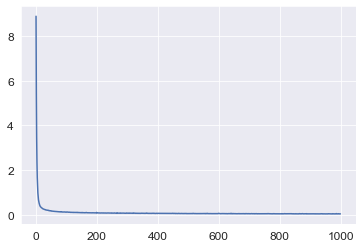

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_54 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_111 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_55 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_113 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

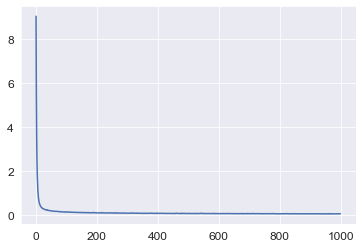

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_56 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_115 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_57 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_116 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

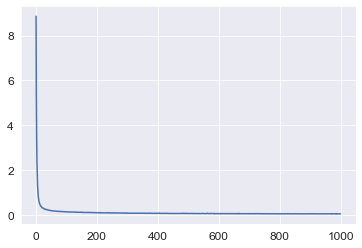

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_118 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_58 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_119 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_59 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_120 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_121 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

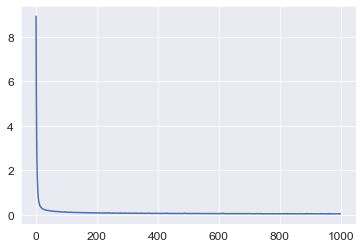

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_122 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_60 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_123 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_61 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_124 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_125 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

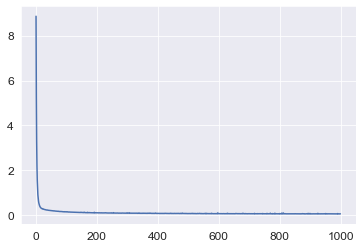

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_126 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_62 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_127 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_63 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_128 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

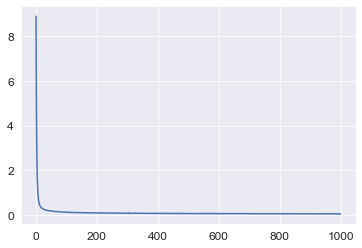

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_64 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_131 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_65 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_132 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_133 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

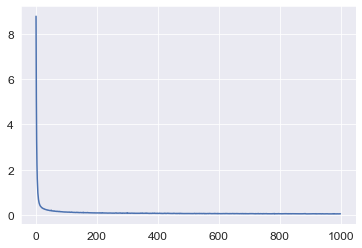

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_134 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_66 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_135 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_67 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_136 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_137 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

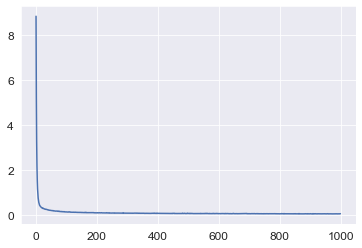

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_138 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_68 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_139 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_69 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_140 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_141 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

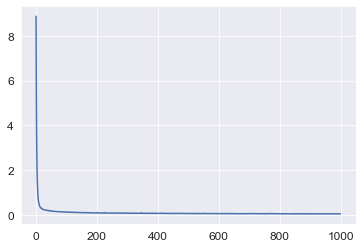

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_142 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_70 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_143 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_71 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_144 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_145 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

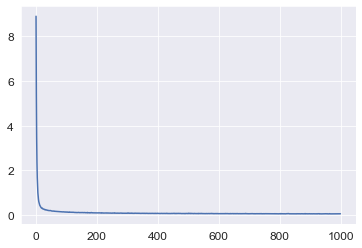

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_146 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_72 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_147 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_73 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_148 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_149 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

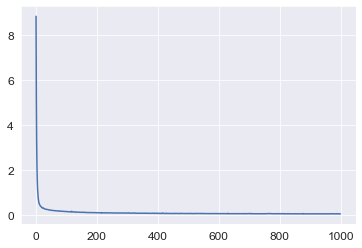

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_150 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_74 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_151 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_75 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_152 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

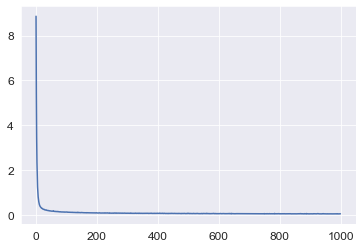

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_154 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_76 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_155 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_77 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_156 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_157 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

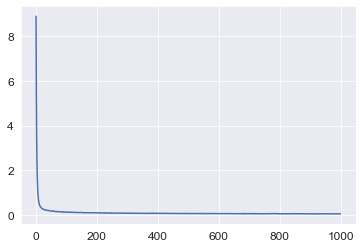

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_158 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_78 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_159 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_79 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_160 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_161 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

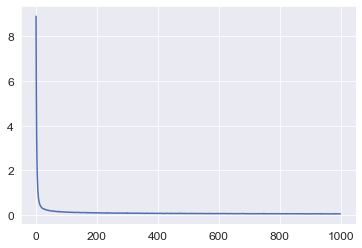

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_162 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_80 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_163 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_81 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_164 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_165 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

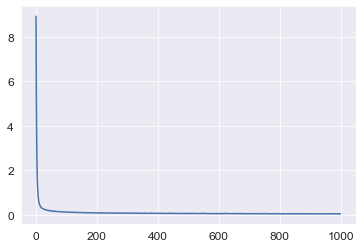

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_166 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_82 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_167 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_83 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_168 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_169 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

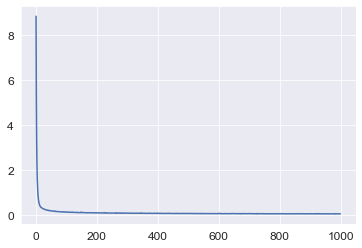

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_170 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_84 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_171 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_85 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_172 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_173 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

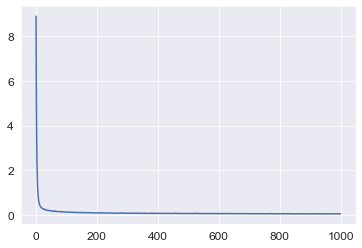

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_174 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_86 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_175 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_87 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_176 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_177 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

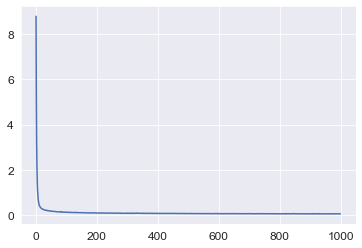

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_178 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_88 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_179 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_89 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_180 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_181 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

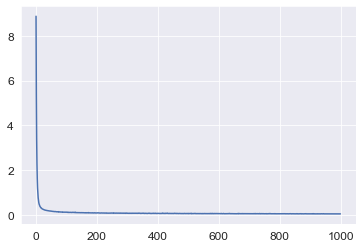

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_182 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_90 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_183 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_91 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_184 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_185 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

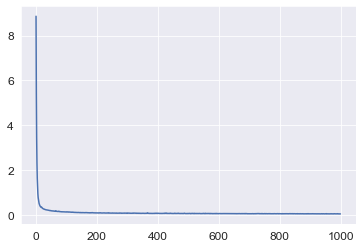

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_186 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_92 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_187 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_93 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_188 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_189 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

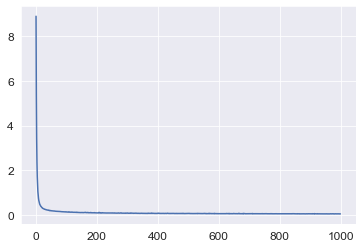

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_190 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_94 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_191 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_95 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_192 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_193 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

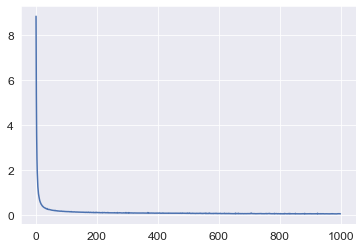

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_194 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_96 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_195 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_97 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_196 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_197 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

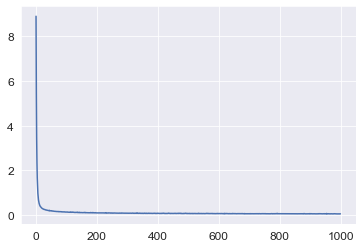

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_198 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_98 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_199 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_99 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_200 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_201 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

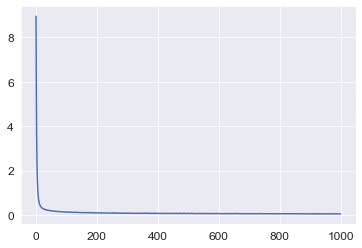

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_202 (Dense)            (None, 512)               8704      
_________________________________________________________________
dropout_100 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_203 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_101 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_204 (Dense)            (None, 512)               262144    
_________________________________________________________________
dense_205 (Dense)            (None, 1)                 513       
Total params: 534,017
Trainable params: 534,017
Non-trainable params: 0
_______________________________________________

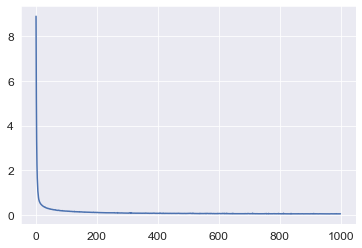

Detailed accuracy performance of MLNN:
+-----------+--------------------+---------------+--------------------+
|           |    Loss function   |      AUC      |     Accuracy       |
+-----------+--------------------+---------------+--------------------+
|    Max    |       0.247        |      1.0      |        0.99        |
|    Min    |       0.067        |     0.969     |       0.942        |
|    Mean   |        0.13        |     0.994     |       0.969        |
|   StDev   |       0.046        |     0.007     |       0.011        |
+-----------+--------------------+---------------+--------------------+


In [172]:

#Neural Network Hyperparameters

np.random.seed(1)
ml_loss = []
ml_auc = []
ml_accuracy = []
for times in range(100):
    X_train, X_test, y_train, y_test = train_test_split(data_p, data_labels, train_size = 0.8, shuffle=True)
    X_train,y_train = smote.fit_resample(X_train,y_train)
    input_dim = 16
    num_classes = 1
    num_epochs = 1000
    layer_dim = 1
    learning_rate = 0.001
    batch_size =32#int(opt)32
    dropout=0.05
    hidden_dim=512
    output_activation = 'sigmoid'
    initial_activation = 'relu'
    kernel_initializer="glorot_uniform"
    bias_initializer="glorot_uniform"
    loss_function=tf.keras.losses.BinaryCrossentropy()
    optimiser=optimizers.Adamax(lr=learning_rate)
    metric=tf.keras.metrics.AUC()#,tf.keras.metrics.Accuracy()
    kernel_regularizer='l2'#,'l1_l2'
    
    ##Building the MLP
            
    history = History()
    model = Sequential()
    
    #Add input layer
    model.add(Dense(hidden_dim, input_dim=input_dim, activation=initial_activation, use_bias=True, bias_initializer=bias_initializer, kernel_initializer=kernel_initializer,kernel_regularizer=kernel_regularizer))
    model.add(Dropout(dropout))
    #Add hidden layer
    model.add(Dense(hidden_dim, activation=initial_activation, use_bias=True, bias_initializer=bias_initializer, kernel_initializer=kernel_initializer,kernel_regularizer=kernel_regularizer))
    model.add(Dropout(dropout))
    #Add hidden layer
    model.add(Dense(hidden_dim, activation=initial_activation, use_bias=False, bias_initializer=bias_initializer, kernel_initializer=kernel_initializer,kernel_regularizer=kernel_regularizer))
    
    #Add output layer
    model.add(Dense(units=num_classes, activation=output_activation))
       
    sgd=optimizers.Adamax(lr=learning_rate)     
    model.compile(loss=loss_function,
                  optimizer=optimiser,
                  metrics=[metric,'accuracy']) 
    print(model.summary())
    callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 300)
    model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=0, callbacks=[callback, history])
    plt.plot(history.history['loss'], label='train')
    plt.show()
    
    #Model Evaluation
    score =(loss, AUC,accuracy) = model.evaluate(X_test, y_test, verbose=0)
    #y_pred=model.predict(X_test)
    #print('Test AUC (from sklearn):',custom_auc(y_test, y_pred))
    ml_loss.append(score[0])
    ml_auc.append(score[1])
    ml_accuracy.append(score[2])
    #print('Test loss:',score[0])
    #print('Test AUC (from tf):',score[1])
    #print('Test accuracy:',score[2])
# calculate testing accuracy
#print(ml_loss,ml_auc,ml_accuracy)

Model_Table = PrettyTable()
Model_Table.field_names = [" ", "   Loss function  ", "     AUC     ", "    Accuracy      "]
Model_Table.add_row(["  Max  ", round(max(ml_loss),3), round(max(ml_auc),3), round(max(ml_accuracy),3)])
Model_Table.add_row(["  Min  ", round(min(ml_loss),3),round(min(ml_auc),3),round(min(ml_accuracy),3)])
Model_Table.add_row(["  Mean  ", round(stats.mean(ml_loss),3),round(stats.mean(ml_auc),3),round(stats.mean(ml_accuracy),3)])
Model_Table.add_row(["  StDev  ", round(stats.stdev(ml_loss),3),round(stats.stdev(ml_auc),3),round(stats.stdev(ml_accuracy),3)])
print("Detailed accuracy performance of MLNN:")
print(Model_Table)#

# Feature Selection

In [90]:
#Forest parameter 
from sklearn.feature_selection import SelectFromModel

From pearson correlation coefficient we had that itching is the least correlated with our outcome and from feature selection we had that weakness and obesity are least important. We will try and remove each of those and see how the Randon Forest classifier will perform, as it is the algorythm with the best performance.

In [173]:
forest = RandomForestClassifier(random_state=1)
# Drop itching
data_sel = data_p.drop('Itching', axis = 1)
#drop weakness
data_sel1 = data_p.drop('weakness', axis = 1)
#drop itching and delayed healing
data_sel2 = data_p.drop(['weakness','Obesity'], axis = 1)
#drop itching, delayed healing and obesity 
data_sel3 = data_p.drop(['Itching','delayed healing', 'Obesity'], axis = 1)

In [174]:
stat_forest = []

AUC_forest = []
forest = RandomForestClassifier(random_state=1, criterion= 'gini', max_features= 2, n_estimators= 50)
for times in range(200):
    df_train, df_test,train_labels,test_labels = train_test_split(data_sel, data_labels, train_size = 0.8, shuffle=True)
    #df_train,train_labels = smote.fit_resample(df_train,train_labels)
    
    
    
    
    forest.fit(df_train,train_labels)
    f_probs = forest.predict_proba(df_test)[:, 1]
    forest_auc = roc_auc_score(test_labels,f_probs)
    stat_forest.append(forest.score(df_test, test_labels))
    
    AUC_forest.append(forest_auc)
print("  Mean AUC ", round(stats.mean(AUC_forest),3),"  Mean ACC ", round(stats.mean(stat_forest),3)) 
    

  Mean AUC  0.999   Mean ACC  0.981


In [175]:
stat_forest = []

AUC_forest = []
forest = RandomForestClassifier(random_state=1, criterion= 'gini', max_features= 2, n_estimators= 50)
for times in range(200):
    df_train, df_test,train_labels,test_labels = train_test_split(data_sel1, data_labels, train_size = 0.8, shuffle=True)
    df_train,train_labels = smote.fit_resample(df_train,train_labels)
    
    
    
    
    forest.fit(df_train,train_labels)
    f_probs = forest.predict_proba(df_test)[:, 1]
    forest_auc = roc_auc_score(test_labels,f_probs)
    stat_forest.append(forest.score(df_test, test_labels))
    
    AUC_forest.append(forest_auc)
print("  Mean AUC ", round(stats.mean(AUC_forest),3),"  Mean ACC ", round(stats.mean(stat_forest),3)) 

  Mean AUC  0.999   Mean ACC  0.984


In [176]:
stat_forest = []

AUC_forest = []
forest = RandomForestClassifier(random_state=1, criterion= 'gini', max_features= 2, n_estimators= 50)
for times in range(200):
    df_train, df_test,train_labels,test_labels = train_test_split(data_sel2, data_labels, train_size = 0.8, shuffle=True)
    #df_train,train_labels = smote.fit_resample(df_train,train_labels)
    
    
    
    
    forest.fit(df_train,train_labels)
    f_probs = forest.predict_proba(df_test)[:, 1]
    forest_auc = roc_auc_score(test_labels,f_probs)
    stat_forest.append(forest.score(df_test, test_labels))
    
    AUC_forest.append(forest_auc)
print("  Mean AUC ", round(stats.mean(AUC_forest),3),"  Mean ACC ", round(stats.mean(stat_forest),3)) 

  Mean AUC  0.999   Mean ACC  0.979


In [177]:
stat_forest = []

AUC_forest = []
forest = RandomForestClassifier(random_state=1, criterion= 'gini', max_features= 2, n_estimators= 50)
for times in range(200):
    df_train, df_test,train_labels,test_labels = train_test_split(data_sel3, data_labels, train_size = 0.8, shuffle=True)
    #df_train,train_labels = smote.fit_resample(df_train,train_labels)
    
    
    
    
    forest.fit(df_train,train_labels)
    f_probs = forest.predict_proba(df_test)[:, 1]
    forest_auc = roc_auc_score(test_labels,f_probs)
    stat_forest.append(forest.score(df_test, test_labels))
    
    AUC_forest.append(forest_auc)
print("  Mean AUC ", round(stats.mean(AUC_forest),3),"  Mean ACC ", round(stats.mean(stat_forest),3)) 

  Mean AUC  0.999   Mean ACC  0.98
